# Importando todas Bibliotecas



In [41]:
# Oculta warnings do notebook
import warnings
warnings.filterwarnings('ignore')


# Raspagem de dados Twitter
%pip install snscrape tqdm 

from datetime import datetime
from dataclasses import fields
from tqdm import tqdm
from scipy.stats import pearsonr as pearson

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import snscrape.modules.twitter as sntwitter

pd.set_option('display.max_columns', 80) # DataFrame com mais de 80 colunas será exibido com uma quebra de linha para mostrar todas as colunas
pd.options.display.float_format = '{:,.2f}'.format # números serão exibidos com duas casas decimais e separadores de milhares

Note: you may need to restart the kernel to use updated packages.


# Leitura dos dados

In [5]:
%%time 
# Carregando dataset com os dados dos candidatos de SP nas eleições de 2022
list_cand_tse = pd.read_csv("deputados-estaduais-sp-2023-03.csv", sep=';')
print(list_cand_tse.shape)

(3659, 71)
CPU times: total: 125 ms
Wall time: 214 ms


In [6]:
%%time 
# Carregando dataset com os dados de redes sociais dos candidatos de SP nas eleições de 2022
rs_df = pd.read_csv("rede_social_candidato_2022_SP.csv", sep=';')
print(rs_df.shape)

(6735, 11)
CPU times: total: 78.1 ms
Wall time: 233 ms


# Limpando e Analisando os dados

### Dados dos candidatos a deputado estadual - SP 
Eleições de 2022

In [7]:
list_cand_tse.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3659 entries, 0 to 3658
Data columns (total 71 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DT_GERACAO                     3659 non-null   object 
 1   HH_GERACAO                     3659 non-null   object 
 2   ANO_ELEICAO                    3659 non-null   int64  
 3   CD_TIPO_ELEICAO                3659 non-null   int64  
 4   NM_TIPO_ELEICAO                3659 non-null   object 
 5   NR_TURNO                       3659 non-null   int64  
 6   CD_ELEICAO                     3659 non-null   int64  
 7   DS_ELEICAO                     3659 non-null   object 
 8   DT_ELEICAO                     3659 non-null   object 
 9   TP_ABRANGENCIA                 3659 non-null   object 
 10  SG_UF                          3659 non-null   object 
 11  SG_UE                          3659 non-null   object 
 12  NM_UE                          3659 non-null   o

In [8]:
list_cand_tse.head(4)

DT_GERACAO HH_GERACAO  ANO_ELEICAO  CD_TIPO_ELEICAO    NM_TIPO_ELEICAO   
0  15/02/2023   18:42:41         2022                2  ELEIÇÃO ORDINÁRIA  \
1  15/02/2023   18:42:41         2022                2  ELEIÇÃO ORDINÁRIA   
2  15/02/2023   18:42:41         2022                2  ELEIÇÃO ORDINÁRIA   
3  15/02/2023   18:42:41         2022                2  ELEIÇÃO ORDINÁRIA   

   NR_TURNO  CD_ELEICAO                      DS_ELEICAO  DT_ELEICAO   
0         1         546  Eleições Gerais Estaduais 2022  02/10/2022  \
1         1         546  Eleições Gerais Estaduais 2022  02/10/2022   
2         1         546  Eleições Gerais Estaduais 2022  02/10/2022   
3         1         546  Eleições Gerais Estaduais 2022  02/10/2022   

  TP_ABRANGENCIA SG_UF SG_UE      NM_UE  CD_CARGO           DS_CARGO   
0       ESTADUAL    SP    SP  SÃO PAULO         6   DEPUTADO FEDERAL  \
1       ESTADUAL    SP    SP  SÃO PAULO         7  DEPUTADO ESTADUAL   
2       ESTADUAL    SP    SP  SÃO PAULO         7  DEPUTADO ESTADUAL   
3       ESTADUAL    SP    SP  SÃO PAULO         7  DEPUTADO ESTADUAL   

   SQ_CANDIDATO  NR_CANDIDATO                              NM_CANDIDATO   
0  250001620283          4025                    WALTER JOSÉ DOS SANTOS  \
1  250001721333         36422  SEVERINO DOS RAMOS LAURENTINO DOS SANTOS   
2  250001602111         44888                     WALTER MARTINS JUNIOR   
3  250001610149         22181                    HUGO PEREIRA DE CASTRO   

       NM_URNA_CANDIDATO NM_SOCIAL_CANDIDATO  NR_CPF_CANDIDATO   
0               O WARTÃO              #NULO#       10938271814  \
1    SEVERINO LAURENTINO              #NULO#       13372766857   
2  WALTER MARTINS JÚNIOR              #NULO#       40182490807   
3          DELEGADO HUGO              #NULO#       92913148620   

         NM_EMAIL  CD_SITUACAO_CANDIDATURA DS_SITUACAO_CANDIDATURA   
0  NÃO DIVULGÁVEL                       12                    APTO  \
1  NÃO DIVULGÁVEL                        3                  INAPTO   
2  NÃO DIVULGÁVEL                       12                    APTO   
3  NÃO DIVULGÁVEL                       12                    APTO   

   CD_DETALHE_SITUACAO_CAND DS_DETALHE_SITUACAO_CAND    TP_AGREMIACAO   
0                         2                 DEFERIDO  PARTIDO ISOLADO  \
1                         6                 RENÚNCIA  PARTIDO ISOLADO   
2                         2                 DEFERIDO  PARTIDO ISOLADO   
3                         2                 DEFERIDO  PARTIDO ISOLADO   

   NR_PARTIDO SG_PARTIDO                     NM_PARTIDO  NR_FEDERACAO   
0          40        PSB  PARTIDO SOCIALISTA BRASILEIRO            -1  \
1          36       AGIR                           AGIR            -1   
2          44      UNIÃO                   UNIÃO BRASIL            -1   
3          22         PL                PARTIDO LIBERAL            -1   

  NM_FEDERACAO SG_FEDERACAO DS_COMPOSICAO_FEDERACAO  SQ_COLIGACAO   
0       #NULO#       #NULO#                  #NULO#  250001682213  \
1       #NULO#       #NULO#                  #NULO#  250001685371   
2       #NULO#       #NULO#                  #NULO#  250001681143   
3       #NULO#       #NULO#                  #NULO#  250001681492   

      NM_COLIGACAO DS_COMPOSICAO_COLIGACAO  CD_NACIONALIDADE DS_NACIONALIDADE   
0  PARTIDO ISOLADO                     PSB                 1  BRASILEIRA NATA  \
1  PARTIDO ISOLADO                    AGIR                 1  BRASILEIRA NATA   
2  PARTIDO ISOLADO                   UNIÃO                 1  BRASILEIRA NATA   
3  PARTIDO ISOLADO                      PL                 1  BRASILEIRA NATA   

  SG_UF_NASCIMENTO  CD_MUNICIPIO_NASCIMENTO NM_MUNICIPIO_NASCIMENTO   
0               SP                       -3             NOVA ODESSA  \
1               SP                       -3                 GUARUJÁ   
2               SP                       -3    SÃO JOAQUIM DA BARRA   
3               MG                       -3          CARMO DE MINAS   

  

### Redes sociais dos candidatos a deputado estadual 
eleições de 2022

In [9]:
rs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6735 entries, 0 to 6734
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   DT_GERACAO       6735 non-null   object
 1   HH_GERACAO       6735 non-null   object
 2   AA_ELEICAO       6735 non-null   int64 
 3   SG_UF            6735 non-null   object
 4   CD_TIPO_ELEICAO  6735 non-null   int64 
 5   NM_TIPO_ELEICAO  6735 non-null   object
 6   CD_ELEICAO       6735 non-null   int64 
 7   DS_ELEICAO       6735 non-null   object
 8   SQ_CANDIDATO     6735 non-null   int64 
 9   NR_ORDEM         6735 non-null   int64 
 10  DS_URL           6735 non-null   object
dtypes: int64(5), object(6)
memory usage: 578.9+ KB


In [10]:
rs_df.head()

DT_GERACAO HH_GERACAO  AA_ELEICAO SG_UF  CD_TIPO_ELEICAO   
0  15/02/2023   18:43:54        2022    SP                2  \
1  15/02/2023   18:43:54        2022    SP                2   
2  15/02/2023   18:43:54        2022    SP                2   
3  15/02/2023   18:43:54        2022    SP                2   
4  15/02/2023   18:43:54        2022    SP                2   

     NM_TIPO_ELEICAO  CD_ELEICAO                      DS_ELEICAO   
0  ELEIÇÃO ORDINÁRIA         546  ELEIÇÕES GERAIS ESTADUAIS 2022  \
1  ELEIÇÃO ORDINÁRIA         546  ELEIÇÕES GERAIS ESTADUAIS 2022   
2  ELEIÇÃO ORDINÁRIA         546  ELEIÇÕES GERAIS ESTADUAIS 2022   
3  ELEIÇÃO ORDINÁRIA         546  ELEIÇÕES GERAIS ESTADUAIS 2022   
4  ELEIÇÃO ORDINÁRIA         546  ELEIÇÕES GERAIS ESTADUAIS 2022   

   SQ_CANDIDATO  NR_ORDEM                                        DS_URL  
0  250001613784         4  https://www.linkedin.com/in/eusoumaisadiniz/  
1  250001613784         5           https://twitter.com/eusoumaisadiniz  
2  250001613784         2    https://www.instagram.com/eusoumaisadiniz/  
3  250001613784         6          https://www.kwai.com/eusoumaisadiniz  
4  250001613784         1                 https://www.maisadiniz.com.br

In [11]:
%%time 
# Filtrando somente candidatos com conta no Twitter
rs_twitter_df = rs_df[rs_df.DS_URL.str.contains('twitter', case=False)]
print(rs_twitter_df.shape)

(624, 11)
CPU times: total: 15.6 ms
Wall time: 120 ms


In [12]:
%%time 
# Juntando as duas bases
df = pd.merge(list_cand_tse, rs_twitter_df[['SQ_CANDIDATO', 'DS_URL']], on="SQ_CANDIDATO", how="left")
df.shape

CPU times: total: 15.6 ms
Wall time: 501 ms


(3682, 72)

In [13]:
# Filtrando somente candidatos a deputado estadual
candidates_df = df.loc[
    (df['DS_CARGO'] == 'DEPUTADO ESTADUAL')
]

print(candidates_df.shape)

(2068, 72)


In [14]:
df.head(3)

DT_GERACAO HH_GERACAO  ANO_ELEICAO  CD_TIPO_ELEICAO    NM_TIPO_ELEICAO   
0  15/02/2023   18:42:41         2022                2  ELEIÇÃO ORDINÁRIA  \
1  15/02/2023   18:42:41         2022                2  ELEIÇÃO ORDINÁRIA   
2  15/02/2023   18:42:41         2022                2  ELEIÇÃO ORDINÁRIA   

   NR_TURNO  CD_ELEICAO                      DS_ELEICAO  DT_ELEICAO   
0         1         546  Eleições Gerais Estaduais 2022  02/10/2022  \
1         1         546  Eleições Gerais Estaduais 2022  02/10/2022   
2         1         546  Eleições Gerais Estaduais 2022  02/10/2022   

  TP_ABRANGENCIA SG_UF SG_UE      NM_UE  CD_CARGO           DS_CARGO   
0       ESTADUAL    SP    SP  SÃO PAULO         6   DEPUTADO FEDERAL  \
1       ESTADUAL    SP    SP  SÃO PAULO         7  DEPUTADO ESTADUAL   
2       ESTADUAL    SP    SP  SÃO PAULO         7  DEPUTADO ESTADUAL   

   SQ_CANDIDATO  NR_CANDIDATO                              NM_CANDIDATO   
0  250001620283          4025                    WALTER JOSÉ DOS SANTOS  \
1  250001721333         36422  SEVERINO DOS RAMOS LAURENTINO DOS SANTOS   
2  250001602111         44888                     WALTER MARTINS JUNIOR   

       NM_URNA_CANDIDATO NM_SOCIAL_CANDIDATO  NR_CPF_CANDIDATO   
0               O WARTÃO              #NULO#       10938271814  \
1    SEVERINO LAURENTINO              #NULO#       13372766857   
2  WALTER MARTINS JÚNIOR              #NULO#       40182490807   

         NM_EMAIL  CD_SITUACAO_CANDIDATURA DS_SITUACAO_CANDIDATURA   
0  NÃO DIVULGÁVEL                       12                    APTO  \
1  NÃO DIVULGÁVEL                        3                  INAPTO   
2  NÃO DIVULGÁVEL                       12                    APTO   

   CD_DETALHE_SITUACAO_CAND DS_DETALHE_SITUACAO_CAND    TP_AGREMIACAO   
0                         2                 DEFERIDO  PARTIDO ISOLADO  \
1                         6                 RENÚNCIA  PARTIDO ISOLADO   
2                         2                 DEFERIDO  PARTIDO ISOLADO   

   NR_PARTIDO SG_PARTIDO                     NM_PARTIDO  NR_FEDERACAO   
0          40        PSB  PARTIDO SOCIALISTA BRASILEIRO            -1  \
1          36       AGIR                           AGIR            -1   
2          44      UNIÃO                   UNIÃO BRASIL            -1   

  NM_FEDERACAO SG_FEDERACAO DS_COMPOSICAO_FEDERACAO  SQ_COLIGACAO   
0       #NULO#       #NULO#                  #NULO#  250001682213  \
1       #NULO#       #NULO#                  #NULO#  250001685371   
2       #NULO#       #NULO#                  #NULO#  250001681143   

      NM_COLIGACAO DS_COMPOSICAO_COLIGACAO  CD_NACIONALIDADE DS_NACIONALIDADE   
0  PARTIDO ISOLADO                     PSB                 1  BRASILEIRA NATA  \
1  PARTIDO ISOLADO                    AGIR                 1  BRASILEIRA NATA   
2  PARTIDO ISOLADO                   UNIÃO                 1  BRASILEIRA NATA   

  SG_UF_NASCIMENTO  CD_MUNICIPIO_NASCIMENTO NM_MUNICIPIO_NASCIMENTO   
0               SP                       -3             NOVA ODESSA  \
1               SP                       -3                 GUARUJÁ   
2               SP                       -3    SÃO JOAQUIM DA BARRA   

  DT_NASCIMENTO  NR_IDADE_DATA_POSSE  NR_TITULO_ELEITORAL_CANDIDATO   
0    05/03/1967                55.00                    52316580116  \
1    08/07/1973                49.00                   192932660175   
2    07/07/1990                32.00                   373849030167   

   CD_GENERO  DS_GENERO  CD_GRAU_INSTRUCAO      DS_GRAU_INSTRUCAO   
0          2  MASCULINO                  6  ENSINO MÉDIO COMPLETO  \
1          2  MASCULINO                  8      SUPERIOR COMPLETO   
2          2  MASCULINO                  8      SUPERIOR COMPLETO   

   CD_ESTADO_CIVIL DS_ESTADO_CIVIL  CD_COR_RACA DS_COR_RACA  CD_OCUPACAO   
0                3       CASADO(A)            1      BRANCA          241  \
1                3       CASADO(A)            2       PRETA          999   
2         

# Analisando contas do Twitter
* Verifica candidatos duplicados

In [15]:
duplicated_candidates_id = candidates_df['SQ_CANDIDATO'].duplicated(keep=False)

if duplicated_candidates_id.sum() == 0:
    print("Não foram encontrados candidatos duplicados na coluna 'SQ_CANDIDATO'.")
else:
    duplicated_candidates_df = candidates_df[duplicated_candidates_id][['SQ_CANDIDATO', 'DS_URL']]
    duplicated_candidates_df = duplicated_candidates_df[duplicated_candidates_df['SQ_CANDIDATO'].duplicated(keep=False)]
    if len(duplicated_candidates_df) == 0:
        print("Não foram encontrados candidatos duplicados na coluna 'SQ_CANDIDATO'.")
    else:
        print("Os seguintes candidatos estão duplicados na coluna 'SQ_CANDIDATO':")
        print(duplicated_candidates_df)

Os seguintes candidatos estão duplicados na coluna 'SQ_CANDIDATO':
      SQ_CANDIDATO                                             DS_URL
179   250001643640                https://twitter.com/DrMarcioAurelio
180   250001643640                https://twitter.com/DrMarcioAurelio
181   250001643640                https://twitter.com/raiztrabalhista
578   250001619366  https://twitter.com/MarinadaMantiq1?t=8vFxK3Hx...
579   250001619366  https://twitter.com/Mantiqueira18?t=hLpMVYYVZ0...
885   250001611799                   https://twitter.com/depeniotatto
886   250001611799             https://www.twitter.com/eniotatto13114
2344  250001620657                https://www.twitter.com/FabioAdonis
2345  250001620657  https://twitter.com/fabiojabaDGtal?t=45hkTz2X4...
2688  250001611457                     https://twitter.com/alefrota77
2689  250001611457                       https://twitter.com/77_frota
2783  250001620598               https://www.twitter.com/@Gnobrega007
2784  250001620598     

In [16]:
# Vamos checar estas contas no Twitter
drop_list = []

# A conta DrMarcioAurelio está repetida, portanto vamos remover uma das linhas
drop_list.append(180)

# A conta raiztrabalhista é de um coletivo político e não do candidato
drop_list.append(181)

# A conta Mantiqueira18 é de um coletivo político e não do candidato
drop_list.append(579)

# A conta eniotatto13114 não existe mais
drop_list.append(886)

# A conta FabioAdonis é pessoal e não posta desde 2017
drop_list.append(2344)

# A conta alefrota77 não existe mais
drop_list.append(2688)

# A conta GeraldóNobrega não existe mais
drop_list.append(2784)

# A conta rodrigo_pt13 não tem nenhum tweet
drop_list.append(3442)

# A conta valverdemogi possui apenas um tweet de 2021
drop_list.append(3443)

# Removendo as contas acima
candidates_df = candidates_df.drop(drop_list)


In [17]:
# Removendo todos os itens da lista columns, são colunas que não iremos utilizar 

columns = ["ANO_ELEICAO", "NM_TIPO_ELEICAO", "NR_TURNO", "CD_ELEICAO", 
           "DS_ELEICAO", "DT_ELEICAO", "TP_ABRANGENCIA", "SG_UF", "SG_UE", 
           "NM_UE", "NR_CPF_CANDIDATO", "NM_EMAIL", "CD_SITUACAO_CANDIDATURA",  
           "NM_FEDERACAO", "SG_FEDERACAO", "DS_COMPOSICAO_FEDERACAO",           
           "NM_COLIGACAO", "NR_TITULO_ELEITORAL_CANDIDATO",               
           "NR_PROTOCOLO_CANDIDATURA", "NR_CANDIDATO", "CD_DETALHE_SITUACAO_CAND",
           "SQ_COLIGACAO", "CD_SIT_TOT_TURNO", "NR_PROCESSO"]

candidates_df = candidates_df.drop(columns=columns)


In [18]:
# Verificando valores ausentes

100*candidates_df.isnull().sum()/candidates_df.shape[0]

DT_GERACAO                      0.00
HH_GERACAO                      0.00
CD_TIPO_ELEICAO                 0.00
CD_CARGO                        0.00
DS_CARGO                        0.00
SQ_CANDIDATO                    0.00
NM_CANDIDATO                    0.00
NM_URNA_CANDIDATO               0.00
NM_SOCIAL_CANDIDATO             0.00
DS_SITUACAO_CANDIDATURA         0.00
DS_DETALHE_SITUACAO_CAND        0.00
TP_AGREMIACAO                   0.00
NR_PARTIDO                      0.00
SG_PARTIDO                      0.00
NM_PARTIDO                      0.00
NR_FEDERACAO                    0.00
DS_COMPOSICAO_COLIGACAO         0.00
CD_NACIONALIDADE                0.00
DS_NACIONALIDADE                0.00
SG_UF_NASCIMENTO                0.00
CD_MUNICIPIO_NASCIMENTO         0.00
NM_MUNICIPIO_NASCIMENTO         0.00
DT_NASCIMENTO                   0.05
NR_IDADE_DATA_POSSE             0.05
CD_GENERO                       0.00
DS_GENERO                       0.00
CD_GRAU_INSTRUCAO               0.00
D

Valor de qui-quadrado: 2228.8324635854797
Valor de p: 0.0


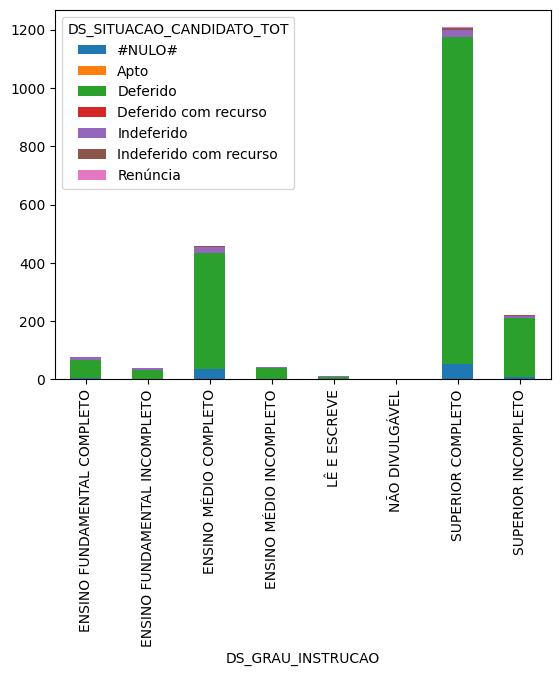

In [19]:
# Análise de associação entre o nível educacional e a situação eleitoral dos candidatos 

from scipy.stats import chi2_contingency

candidates_df['DS_GRAU_INSTRUCAO'] = candidates_df[
    'DS_GRAU_INSTRUCAO'].replace(['Ensino Fundamental', 'Ensino Médio', 'Ensino Técnico'], 'Ensino Médio ou inferior')
candidates_df['DS_GRAU_INSTRUCAO'] = candidates_df[
    'DS_GRAU_INSTRUCAO'].replace(['Superior completo', 'Superior incompleto', 'Pós-graduação', 'Mestrado', 'Doutorado'], 'Ensino Superior')

contingency_table = pd.crosstab(candidates_df['DS_GRAU_INSTRUCAO'], candidates_df['DS_SITUACAO_CANDIDATO_TOT'])
contingency_table.plot(kind='bar', stacked=True)

# Teste de qui-quadrado para avaliar a significância da associação (p)
chi2, p, dof, expected = chi2_contingency(contingency_table) #chi2_contingency = significância da associação
print('Valor de qui-quadrado:', chi2)
print('Valor de p:', p)

# *Associação entre o nível educacional e a situação eleitoral*

*O valor de Qui-Quadrado foi 2228.8324, o que indica que há uma forte relação entre o nível educacional e sua situação eleitoral.*

*Já o valor de p foi 0.0, o que significa que é muito provável a hipótese de que há uma associação real entre as variáveis seja verdadeira.* 

# Exploração dos dados

In [20]:
# Vamos criar diferentes segmentações, para facilitar a comparação de diversidade

elected_values = ['ELEITO POR QP', 'ELEITO POR MÉDIA', 'ELEITO']

In [21]:
# Deputados estaduais eleitos

elected_df = candidates_df.loc[
    (candidates_df['DS_SIT_TOT_TURNO'].isin(elected_values))
]

print(elected_df.shape)

(94, 48)


In [22]:
# Deputados estaduais eleitos com perfil no Twitter

twitter_df = elected_df.loc[
    (elected_df['DS_URL'].notna())
]

print(twitter_df.shape)

(49, 48)


In [23]:
# Comparando turnos da eleição

twitter_df.DS_SIT_TOT_TURNO.value_counts()

DS_SIT_TOT_TURNO
ELEITO POR QP       42
ELEITO POR MÉDIA     7
Name: count, dtype: int64

### Identificando valores extremos

In [24]:
# Calcular a correlação entre as variáveis - Despesa com campanha e Partido

corr = np.corrcoef(twitter_df['VR_DESPESA_MAX_CAMPANHA'], twitter_df['NR_PARTIDO'])
formatted_corr = format(corr[0, 1], ".2f")

print('A correlação entre as variáveis é:', formatted_corr)

A correlação entre as variáveis é: 0.00


### *O valor da correlação é praticamente nulo entre despesa com campanha e partido, pois, está muito próximo de zero (8.541361740010659e-17)*

## Explorando dados dos candidatos eleitos 

In [25]:
#Contagem de partidos políticos eleitos

twitter_df.value_counts('SG_PARTIDO')

SG_PARTIDO
PL              15
PT              12
PSOL             4
PSB              3
UNIÃO            3
CIDADANIA        2
PP               2
PSDB             2
REPUBLICANOS     2
MDB              1
NOVO             1
PODE             1
PSC              1
Name: count, dtype: int64

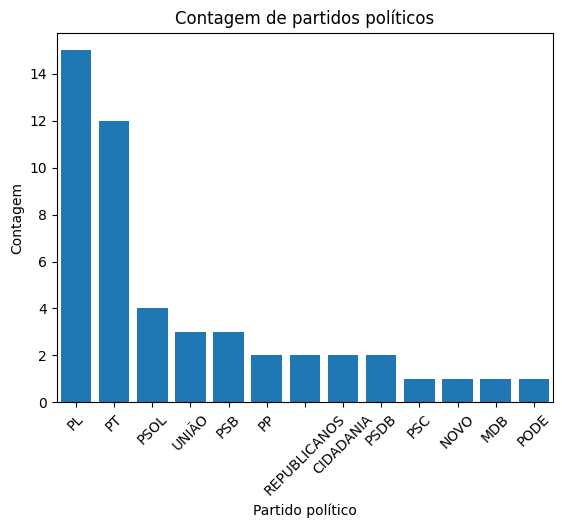

In [26]:
# Gráfico de contagem de partidos políticos eleitos
contagem_eleitos = twitter_df['SG_PARTIDO'].value_counts()

twitter_df['SG_PARTIDO'].value_counts().plot(kind='bar', rot=45)

plt.bar(contagem_eleitos.index, contagem_eleitos.values)
plt.title('Contagem de partidos políticos')
plt.xlabel('Partido político')
plt.ylabel('Contagem')
plt.show()

In [27]:
# Eleitos com conta no Twitter - gênero e raça e contando o número de candidatos

candidates_count = candidates_df.groupby(['DS_GENERO', 'DS_COR_RACA']).size()
elected_count = elected_df.groupby(['DS_GENERO', 'DS_COR_RACA']).size()
twitter_count = twitter_df.groupby(['DS_GENERO', 'DS_COR_RACA']).size()

print('Candidatos a deputado estadual')
print(candidates_count)
print()
print('Candidatos a deputado estadual eleitos')
print(elected_count)
print()
print('Candidatos a deputado estadual eleitos com conta no Twitter')
print(twitter_count)

Candidatos a deputado estadual
DS_GENERO       DS_COR_RACA   
FEMININO        AMARELA             8
                BRANCA            419
                INDÍGENA            2
                PARDA             115
                PRETA             132
MASCULINO       AMARELA            11
                BRANCA            906
                INDÍGENA            4
                NÃO INFORMADO       1
                PARDA             318
                PRETA             142
NÃO DIVULGÁVEL  NÃO DIVULGÁVEL      1
dtype: int64

Candidatos a deputado estadual eleitos
DS_GENERO  DS_COR_RACA
FEMININO   BRANCA         19
           PARDA           1
           PRETA           5
MASCULINO  BRANCA         57
           PARDA           8
           PRETA           4
dtype: int64

Candidatos a deputado estadual eleitos com conta no Twitter
DS_GENERO  DS_COR_RACA
FEMININO   BRANCA         11
           PARDA           1
           PRETA           4
MASCULINO  BRANCA         31
           PARDA   

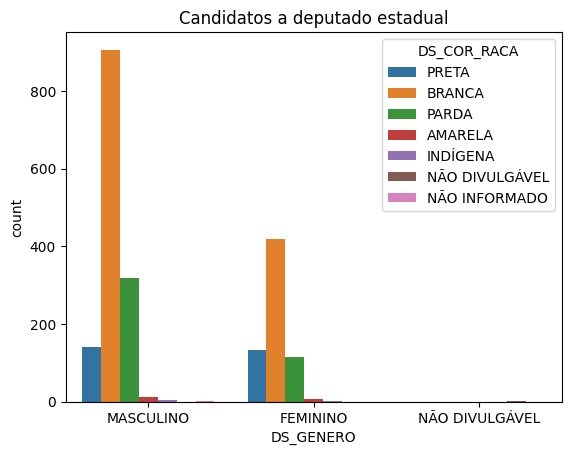

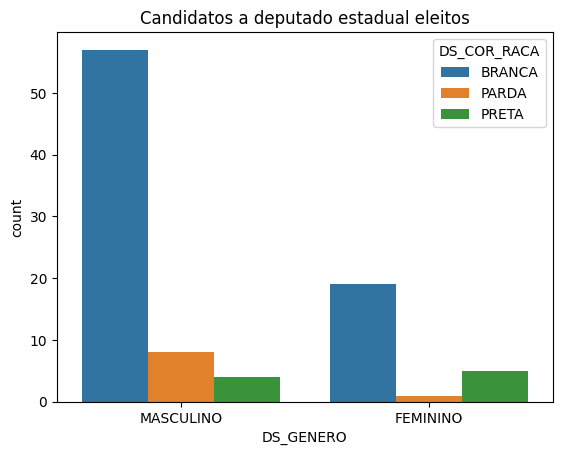

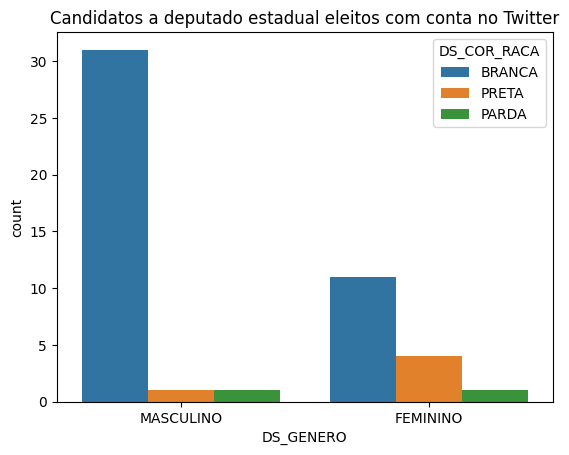

In [28]:
#Visualizando a distribuição de gênero e raça 
##Candidatos a deputado estadual (Geral) 

sns.countplot(data=candidates_df, x='DS_GENERO', hue='DS_COR_RACA')
plt.title('Candidatos a deputado estadual')
plt.show()

# Deputado estadual eleitos - por gênero e raça
sns.countplot(data=elected_df, x='DS_GENERO', hue='DS_COR_RACA')
plt.title('Candidatos a deputado estadual eleitos')
plt.show()

# Eleitos com conta no Twitter - por gênero e raça
sns.countplot(data=twitter_df, x='DS_GENERO', hue='DS_COR_RACA')
plt.title('Candidatos a deputado estadual eleitos com conta no Twitter')
plt.show()

### Visualizando a distribuição
 comparando gênero e partido

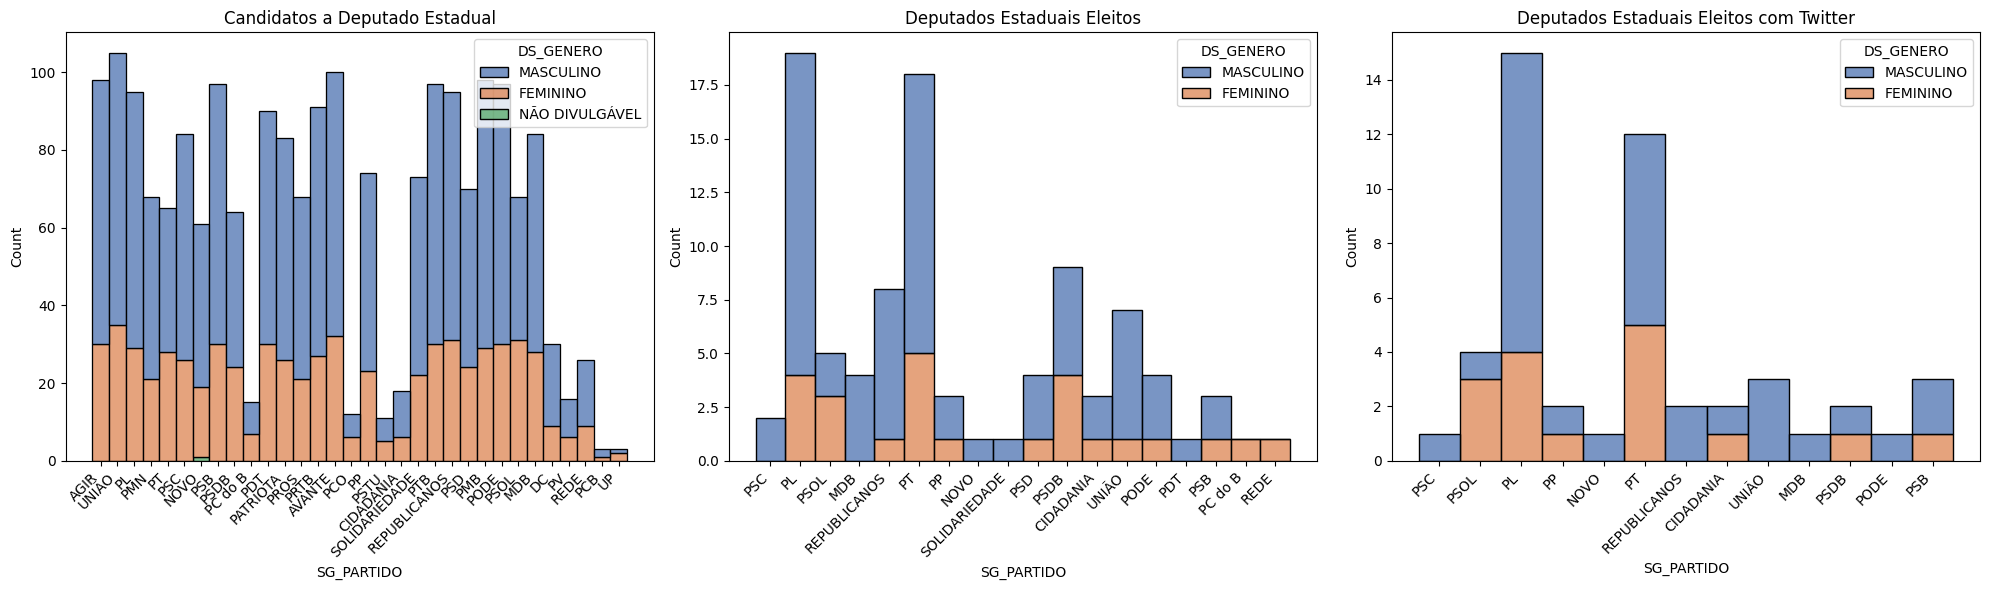

In [29]:
# Candidatos eleitos e com Twitter

fig, ax = plt.subplots(1, 3, figsize=(20, 6), squeeze=False)
fig.autofmt_xdate(rotation=45)

sns.histplot(
    data=candidates_df,
    hue='DS_GENERO',
    x='SG_PARTIDO',
    multiple='stack',
    ax=ax[0][0],
    palette='deep',
).set(title='Candidatos a Deputado Estadual')

sns.histplot(
    data=elected_df,
    hue='DS_GENERO',
    x='SG_PARTIDO',
    multiple='stack',
    ax=ax[0][1],
    palette='deep',
).set(title='Deputados Estaduais Eleitos')

sns.histplot(
    data=twitter_df,
    hue='DS_GENERO',
    x='SG_PARTIDO',
    multiple='stack',
    ax=ax[0][2],
    palette='deep',
).set(title='Deputados Estaduais Eleitos com Twitter')

plt.tight_layout()
plt.show()

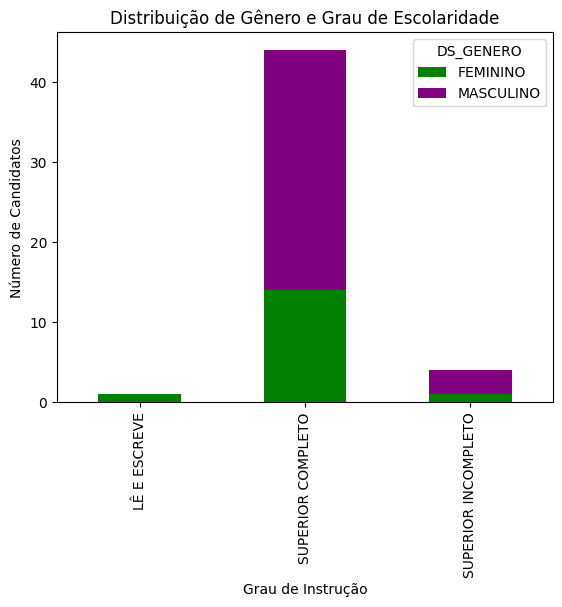

In [30]:
#Visualizando a distribuição - por Gênero e grau de escolaridade

grouped = twitter_df.groupby(['DS_GRAU_INSTRUCAO', 'DS_GENERO'])['SQ_CANDIDATO'].count() # Agrupa os dados por gênero e grau de instrução dos candidatos   
stacked = grouped.unstack().fillna(0) # usando o método unstack - valores ausentes são preenchidos com zero

stacked.plot(kind='bar', stacked=True, color=['Green', 'Purple'])
plt.xlabel('Grau de Instrução')
plt.title('Distribuição de Gênero e Grau de Escolaridade')
plt.ylabel('Número de Candidatos')
plt.show()

In [31]:
#Idade máxima e mínima 

def print_age_stats(df, label): # Imprime estatísticas sobre as idades dos candidatos
    print(f"Idade máxima - {label}: {df['NR_IDADE_DATA_POSSE'].max()}")
    print(f"Idade mínima - {label}: {df['NR_IDADE_DATA_POSSE'].min()}")

print_age_stats(candidates_df, "Deputados estaduais")
print_age_stats(elected_df, "Deputados estaduais eleitos")
print_age_stats(twitter_df, "Deputados estaduais twitter")

Idade máxima - Deputados estaduais: 83.0
Idade mínima - Deputados estaduais: 21.0
Idade máxima - Deputados estaduais eleitos: 81.0
Idade mínima - Deputados estaduais eleitos: 23.0
Idade máxima - Deputados estaduais twitter: 81.0
Idade mínima - Deputados estaduais twitter: 28.0


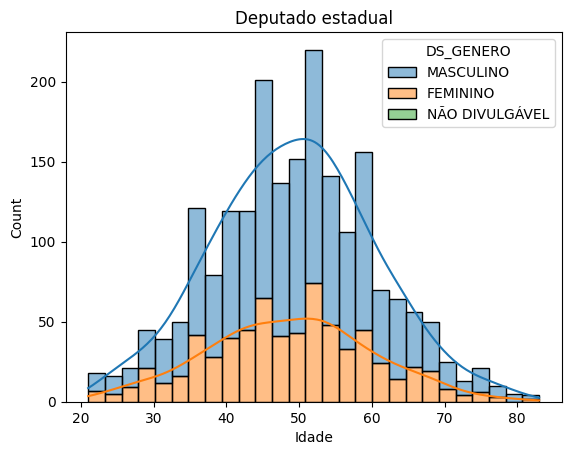

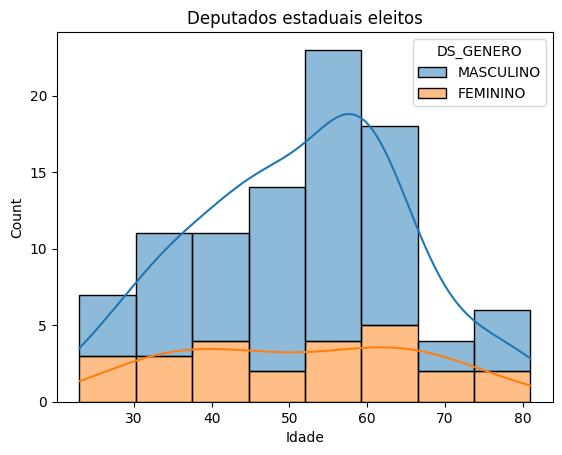

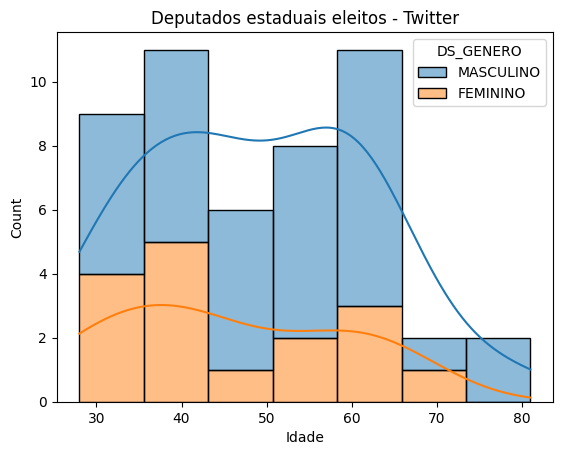

In [32]:
# histogramas empilhando grupos, separando por idade

## kde=True adiciona a curva de densidade do kernel ao histograma
sns.histplot(data=candidates_df, x='NR_IDADE_DATA_POSSE', hue='DS_GENERO', multiple='stack', kde=True) 
plt.title('Deputado estadual')
plt.xlabel('Idade')
plt.show()

sns.histplot(data=elected_df, x='NR_IDADE_DATA_POSSE', hue='DS_GENERO', multiple='stack', kde=True)
plt.title('Deputados estaduais eleitos')
plt.xlabel('Idade')
plt.show()

sns.histplot(data=twitter_df, x='NR_IDADE_DATA_POSSE', hue='DS_GENERO', multiple='stack', kde=True)
plt.title('Deputados estaduais eleitos - Twitter')
plt.xlabel('Idade')
plt.show()

# Dados das Contas do Twitter

In [33]:
# Lista das contas no twitter dos deputados estaduais eleitos

twitter_df.DS_URL

22                          https://www.twitter/dreltonjr
232              https://twitter.com/EdianeMariaMTST?s=09
276     https://twitter.com/fabibbolsonaro?s=21&t=yq90...
318                      https://twitter.com/delegadoolim
367     https://www.twitter.com/https://twitter.com/le...
391     https://twitter.com/bethsahao?ref_src=twsrc%5E...
427                          https://twitter.com/sppretas
458                    https://www.twitter.com/tomeabduch
459                     https://twitter.com/prcarloscezar
490                        https://twitter.com/majormecca
514                      https://twitter.com/valbolsonaro
560                      https://twitter.com/zimbaldirafa
599                    https://twitter.com/CarlosGiannazi
660              https://twitter.com/tenente_coimbra?s=11
690                   https://twitter.com/rafaelsaraivasp
741                    https://twitter.com/BrunoZambelli3
742                      https://twitter.com/LFTeixeira13
810           

In [34]:
#Extraindo contas do Twitter (DS_URL)

def get_twitter_username(link):
    link = link.rstrip('/')
    username = link.split('/')[-1]
    username = username.split('?')[0]
    return username.lower()

twitter_df['TW_USER'] = twitter_df.DS_URL.apply(get_twitter_username)
twitter_df['TW_USER'].describe()

count            49
unique           49
top       dreltonjr
freq              1
Name: TW_USER, dtype: object

In [35]:
# Vamos raspar os dados numéricos de cada uma das contas do Twitter

usernames = list(twitter_df['TW_USER'])

user_data = {}
for i, username in enumerate(usernames):
    try:
        last_tweet = next(sntwitter.TwitterProfileScraper(username).get_items())
        user_data[username] = {
            'followersCount': last_tweet.user.followersCount,
            'friendsCount': last_tweet.user.friendsCount,
            'statusesCount': last_tweet.user.statusesCount,
            'favouritesCount': last_tweet.user.favouritesCount,
            'listedCount': last_tweet.user.listedCount,
            'mediaCount': last_tweet.user.mediaCount,
        }
        print(f'{i+1}/{len(usernames)} {username}: {user_data[username]}')
    except Exception as e:
        print(f'{i+1}/{len(usernames)} {username}: Erro {e}')
        user_data[username] = {
            'followersCount': 0,
            'friendsCount': 0,
            'statusesCount': 0,
            'favouritesCount': 0,
            'listedCount': 0,
            'mediaCount': 0,
        }

1/49 dreltonjr: {'followersCount': 875, 'friendsCount': 461, 'statusesCount': 746, 'favouritesCount': 304, 'listedCount': 2, 'mediaCount': 480}
2/49 edianemariamtst: {'followersCount': 14683, 'friendsCount': 250, 'statusesCount': 3870, 'favouritesCount': 3296, 'listedCount': 41, 'mediaCount': 682}
3/49 fabibbolsonaro: {'followersCount': 15500, 'friendsCount': 7077, 'statusesCount': 102, 'favouritesCount': 500, 'listedCount': 5, 'mediaCount': 41}
4/49 delegadoolim: {'followersCount': 3004, 'friendsCount': 0, 'statusesCount': 1924, 'favouritesCount': 233, 'listedCount': 37, 'mediaCount': 465}
5/49 leosiqueirabr: {'followersCount': 56587, 'friendsCount': 1097, 'statusesCount': 9023, 'favouritesCount': 4961, 'listedCount': 362, 'mediaCount': 1008}
6/49 bethsahao: {'followersCount': 2770, 'friendsCount': 1574, 'statusesCount': 9681, 'favouritesCount': 3872, 'listedCount': 70, 'mediaCount': 545}
7/49 sppretas: {'followersCount': 1800, 'friendsCount': 18, 'statusesCount': 283, 'favouritesCoun

Empty response


8/49 tomeabduch: Erro Could not resolve username 'tomeabduch' to ID
9/49 prcarloscezar: {'followersCount': 5528, 'friendsCount': 585, 'statusesCount': 18302, 'favouritesCount': 254, 'listedCount': 76, 'mediaCount': 1789}
10/49 majormecca: {'followersCount': 28659, 'friendsCount': 980, 'statusesCount': 12505, 'favouritesCount': 25820, 'listedCount': 60, 'mediaCount': 3895}
11/49 valbolsonaro: {'followersCount': 54140, 'friendsCount': 328, 'statusesCount': 4273, 'favouritesCount': 27100, 'listedCount': 122, 'mediaCount': 1313}
12/49 zimbaldirafa: {'followersCount': 1102, 'friendsCount': 353, 'statusesCount': 2525, 'favouritesCount': 130, 'listedCount': 39, 'mediaCount': 378}
13/49 carlosgiannazi: {'followersCount': 21486, 'friendsCount': 833, 'statusesCount': 14550, 'favouritesCount': 14876, 'listedCount': 241, 'mediaCount': 7633}
14/49 tenente_coimbra: {'followersCount': 81006, 'friendsCount': 3013, 'statusesCount': 4481, 'favouritesCount': 4494, 'listedCount': 73, 'mediaCount': 618}
15

Empty response


17/49 lfteixeira13: Erro Could not resolve username 'lfteixeira13' to ID
18/49 emidiodesouza_: {'followersCount': 10392, 'friendsCount': 1090, 'statusesCount': 20286, 'favouritesCount': 5229, 'listedCount': 167, 'mediaCount': 3009}
19/49 esuplicy: {'followersCount': 725186, 'friendsCount': 3688, 'statusesCount': 15044, 'favouritesCount': 6630, 'listedCount': 2204, 'mediaCount': 5620}
20/49 depeniotatto: {'followersCount': 544, 'friendsCount': 205, 'statusesCount': 1361, 'favouritesCount': 171, 'listedCount': 19, 'mediaCount': 232}
21/49 anacarolserra23: {'followersCount': 216, 'friendsCount': 194, 'statusesCount': 45, 'favouritesCount': 1212, 'listedCount': 5, 'mediaCount': 20}
22/49 xerifedoconsum: {'followersCount': 1412, 'friendsCount': 4, 'statusesCount': 686, 'favouritesCount': 0, 'listedCount': 12, 'mediaCount': 180}
23/49 auricchiothiago: {'followersCount': 1026, 'friendsCount': 22, 'statusesCount': 937, 'favouritesCount': 27, 'listedCount': 28, 'mediaCount': 75}
24/49 itamar_bo


### Adicionando os dados dos usuários 

In [36]:

# Quantidade de seguidores da conta
twitter_df['TW_followersCount'] = twitter_df.TW_USER.apply(lambda x: user_data[x]['followersCount'])

# Quantidade de usuarios que a conta segue
twitter_df['TW_friendsCount'] = twitter_df.TW_USER.apply(lambda x: user_data[x]['friendsCount'])

# Quantidade de tweets postados pela conta
twitter_df['TW_statusesCount'] = twitter_df.TW_USER.apply(lambda x: user_data[x]['statusesCount'])

# Quantidade de tweets curtidos pela conta
twitter_df['TW_favouritesCount'] = twitter_df.TW_USER.apply(lambda x: user_data[x]['favouritesCount'])

twitter_df['TW_listedCount'] = twitter_df.TW_USER.apply(lambda x: user_data[x]['listedCount'])
twitter_df['TW_mediaCount'] = twitter_df.TW_USER.apply(lambda x: user_data[x]['mediaCount'])

print(twitter_df.shape)


(49, 55)


In [37]:
# Alterando o nome de algumas colunas (com dados do Twitter)

new_column_names = {
    'TW_followersCount': 'NR_SEGUIDORES',
    'TW_friendsCount': 'NR_CTS_SEGUIDAS',
    'TW_statusesCount': 'NR_TTS_POSTADOS',
    'TW_favouritesCount': 'NR_TTS_CURTIDOS',
    'TW_listedCount': 'NR_CONTA ADD_LISTA',
    'TW_mediaCount': 'NR.MIDIAS_POSTADAS'
}

twitter_df.rename(columns=new_column_names, inplace=True)

print(twitter_df.columns)

Index(['DT_GERACAO', 'HH_GERACAO', 'CD_TIPO_ELEICAO', 'CD_CARGO', 'DS_CARGO',
       'SQ_CANDIDATO', 'NM_CANDIDATO', 'NM_URNA_CANDIDATO',
       'NM_SOCIAL_CANDIDATO', 'DS_SITUACAO_CANDIDATURA',
       'DS_DETALHE_SITUACAO_CAND', 'TP_AGREMIACAO', 'NR_PARTIDO', 'SG_PARTIDO',
       'NM_PARTIDO', 'NR_FEDERACAO', 'DS_COMPOSICAO_COLIGACAO',
       'CD_NACIONALIDADE', 'DS_NACIONALIDADE', 'SG_UF_NASCIMENTO',
       'CD_MUNICIPIO_NASCIMENTO', 'NM_MUNICIPIO_NASCIMENTO', 'DT_NASCIMENTO',
       'NR_IDADE_DATA_POSSE', 'CD_GENERO', 'DS_GENERO', 'CD_GRAU_INSTRUCAO',
       'DS_GRAU_INSTRUCAO', 'CD_ESTADO_CIVIL', 'DS_ESTADO_CIVIL',
       'CD_COR_RACA', 'DS_COR_RACA', 'CD_OCUPACAO', 'DS_OCUPACAO',
       'VR_DESPESA_MAX_CAMPANHA', 'DS_SIT_TOT_TURNO', 'ST_REELEICAO',
       'ST_DECLARAR_BENS', 'CD_SITUACAO_CANDIDATO_PLEITO',
       'DS_SITUACAO_CANDIDATO_PLEITO', 'CD_SITUACAO_CANDIDATO_URNA',
       'DS_SITUACAO_CANDIDATO_URNA', 'ST_CANDIDATO_INSERIDO_URNA',
       'NM_TIPO_DESTINACAO_VOTOS', 'CD_SI

In [38]:
twitter_df.head(2)

DT_GERACAO HH_GERACAO  CD_TIPO_ELEICAO  CD_CARGO           DS_CARGO   
22   15/02/2023   18:42:41                2         7  DEPUTADO ESTADUAL  \
232  15/02/2023   18:42:41                2         7  DEPUTADO ESTADUAL   

     SQ_CANDIDATO                            NM_CANDIDATO NM_URNA_CANDIDATO   
22   250001643810  ELTON ALVES RIBEIRO DE CARVALHO JUNIOR         DR. ELTON  \
232  250001619350              EDIANE MARIA DO NASCIMENTO      EDIANE MARIA   

    NM_SOCIAL_CANDIDATO DS_SITUACAO_CANDIDATURA DS_DETALHE_SITUACAO_CAND   
22               #NULO#                    APTO                 DEFERIDO  \
232              #NULO#                    APTO                 DEFERIDO   

       TP_AGREMIACAO  NR_PARTIDO SG_PARTIDO                      NM_PARTIDO   
22   PARTIDO ISOLADO          20        PSC          PARTIDO SOCIAL CRISTÃO  \
232        FEDERAÇÃO          50       PSOL  PARTIDO SOCIALISMO E LIBERDADE   

     NR_FEDERACAO DS_COMPOSICAO_COLIGACAO  CD_NACIONALIDADE DS_NACIONALIDADE   
22             -1                     PSC                 1  BRASILEIRA NATA  \
232             3               PSOL/REDE                 1  BRASILEIRA NATA   

    SG_UF_NASCIMENTO  CD_MUNICIPIO_NASCIMENTO NM_MUNICIPIO_NASCIMENTO   
22                SP                       -3     SÃO JOSÉ DOS CAMPOS  \
232               PE                       -3                FLORESTA   

    DT_NASCIMENTO  NR_IDADE_DATA_POSSE  CD_GENERO  DS_GENERO   
22     08/07/1974                48.00          2  MASCULINO  \
232    10/10/1983                39.00          4   FEMININO   

     CD_GRAU_INSTRUCAO  DS_GRAU_INSTRUCAO  CD_ESTADO_CIVIL DS_ESTADO_CIVIL   
22                   8  SUPERIOR COMPLETO                3       CASADO(A)  \
232                  2       LÊ E ESCREVE                1     SOLTEIRO(A)   

     CD_COR_RACA DS_COR_RACA  CD_OCUPACAO          DS_OCUPACAO   
22             1      BRANCA          111               MÉDICO  \
232            2       PRETA          598  EMPREGADO DOMÉSTICO   

     VR_DESPESA_MAX_CAMPANHA DS_SIT_TOT_TURNO ST_REELEICAO ST_DECLARAR_BENS   
22              1,270,629.01    ELEITO POR QP            N                S  \
232             1,270,629.01    ELEITO POR QP            N                S   

     CD_SITUACAO_CANDIDATO_PLEITO DS_SITUACAO_CANDIDATO_PLEITO   
22                              2                     DEFERIDO  \
232                             2                     DEFERIDO   

     CD_SITUACAO_CANDIDATO_URNA DS_SITUACAO_CANDIDATO_URNA   
22                            2                   DEFERIDO  \
232                           2                   DEFERIDO   

    ST_CANDIDATO_INSERIDO_URNA NM_TIPO_DESTINACAO_VOTOS   
22                         SIM                   Válido  \
232                        SIM                   Válido   

     CD_SITUACAO_CANDIDATO_TOT DS_SITUACAO_CANDIDATO_TOT ST_PREST_CONTAS   
22                           2                  Deferido               S  \
232                          2                  Deferido               S   

                                       DS_URL          TW_USER  NR_SEGUIDORES   
22              https://www.twitter/dreltonjr        dreltonjr            875  \
232  https://twitter.com/EdianeMariaMTST?s=09  edianemariamtst          14683   

     NR_CTS_SEGUIDAS  NR_TTS_POSTADOS  NR_TTS_CURTIDOS  NR_CONTA ADD_LISTA   
22               461              746              304                   2  \
232              250             3870             3296                  41   

     NR.MIDIAS_POSTADAS  
22                  480  
232                 682

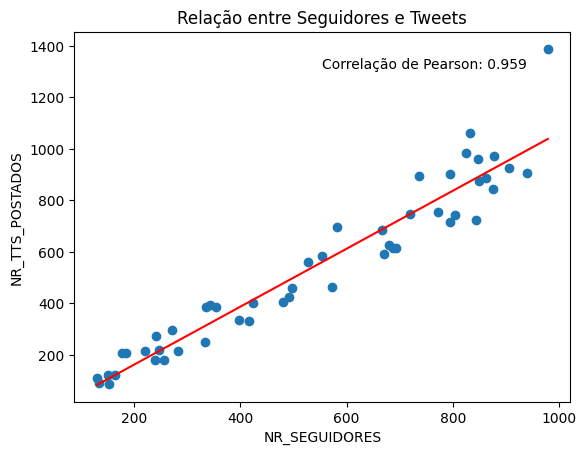

In [39]:
# Correlação de Pearson utilizando as variáveis número de seguidores e tweets

seguidores = np.random.randint(100, 1000, size=50)
tweets = seguidores * np.random.normal(1, 0.2, size=50)

corr = np.corrcoef(seguidores, tweets)[0, 1]

plt.scatter(seguidores, tweets)
plt.title('Relação entre Seguidores e Tweets')
plt.xlabel('NR_SEGUIDORES')
plt.ylabel('NR_TTS_POSTADOS')
plt.plot(np.unique(seguidores), np.poly1d(np.polyfit(seguidores, tweets, 1))(np.unique(seguidores)), color='red')
plt.text(0.5, 0.9, f'Correlação de Pearson: {corr.item():.3f}', transform=plt.gca().transAxes)

plt.show()


 -1 = relaçao negativa  / 
  0 = neutro / 
  1 = relaçao positiva 

***Há uma relação forte entre as variáveis número de seguidores e tweets, sendo ela 0.883***

In [40]:
twitter_df.groupby([
    'TW_USER', 'SG_PARTIDO', 'DS_GENERO'])[['NR_SEGUIDORES', 'NR_CTS_SEGUIDAS', 
    'NR_TTS_POSTADOS', 'NR_TTS_CURTIDOS']].median().sort_values(by=['NR_SEGUIDORES'], ascending=False)

NR_SEGUIDORES  NR_CTS_SEGUIDAS   
TW_USER         SG_PARTIDO   DS_GENERO                                   
esuplicy        PT           MASCULINO     725,186.00         3,688.00  \
carteiroreaca   PL           MASCULINO     533,903.00           855.00   
paulomansur_    PL           MASCULINO     137,018.00        14,467.00   
tenente_coimbra PL           MASCULINO      81,006.00         3,013.00   
andreawerner_   PSB          FEMININO       63,970.00         3,043.00   
leosiqueirabr   NOVO         MASCULINO      56,587.00         1,097.00   
valbolsonaro    PL           FEMININO       54,140.00           328.00   
letsaguiar      PP           FEMININO       34,258.00             0.00   
majormecca      PL           MASCULINO      28,659.00           980.00   
carlosgiannazi  PSOL         MASCULINO      21,486.00           833.00   
danilobalas     PL           MASCULINO      20,244.00           194.00   
fabibbolsonaro  PL           FEMININO       15,500.00         7,077.00   
edianemariamtst PSOL         FEMININO       14,683.00           250.00   
simaopedro_sp   PT           MASCULINO      13,937.00         8,616.00   
depbrunafurlan  PSDB         FEMININO       11,864.00         2,465.00   
contelopes      PL           MASCULINO      10,572.00            32.00   
emidiodesouza_  PT           MASCULINO      10,392.00         1,090.00   
professorabebel PT           FEMININO        9,822.00         2,500.00   
bfeministapsol  PSOL         FEMININO        7,991.00           258.00   
thainarafariapt PT           FEMININO        6,711.00           192.00   
brunozambelli3  PL           MASCULINO       6,053.00            85.00   
caiofranca40    PSB          MASCULINO       5,816.00         1,150.00   
prcarloscezar   PL           MASCULINO       5,528.00           585.00   
lucasbovesp     PL           MASCULINO       5,063.00           112.00   
anaperugini     PT           FEMININO        5,023.00         1,037.00   
delegadoolim    PP           MASCULINO       3,004.00             0.00   
deputadomaurici PT           MASCULINO       2,892.00         2,450.00   
bethsahao       PT           FEMININO        2,770.00         1,574.00   
marcialiapt13   PT           FEMININO        2,727.00         1,656.00   
lcmarcolino     PT           MASCULINO       2,484.00           984.00   
itamar_borges   MDB          MASCULINO       2,235.00            77.00   
edmirchedid     UNIÃO        MASCULINO       2,216.00         1,089.00   
sppretas        PSOL         FEMININO        1,800.00            18.00   
vcamarinha      PSDB         MASCULINO       1,522.00           399.00   
xerifedoconsum  REPUBLICANOS MASCULINO       1,412.00             4.00   
zimbaldirafa    CIDADANIA    MASCULINO       1,102.00           353.00   
auricchiothiago PL           MASCULINO       1,026.00            22.00   
rafaelsaraivasp UNIÃO        MASCULINO         935.00            55.00   
dreltonjr       PSC          MASCULINO         875.00           461.00   
marcosdamasiosp PL           MASCULINO         736.00            37.00   
depeniotatto    PT           MASCULINO         544.00           205.00   
deleg_graciela  PL           FEMININO          444.00             0.00   
anacarolserra23 CIDADANIA    FEMININO          216.00           194.00   
danialonsoda    PL           FEMININO          206.00            25.00   
valdomirolopes_ PSB          MASCULINO         161.00           131.00   
danielbrsoares  UNIÃO        MASCULINO         137.00             8.00   
gersonpessoa    PODE         MASCULINO          73.00            83.00   
lfteixeira13    PT           MASCULINO           0.00             0.00   
tomeabduch      REPUBLICANOS MASCULINO           0.00             0.00   

                                        NR_TTS_POSTADOS  NR_TTS_CURTIDOS  
TW_USER         SG_PARTIDO   DS_GENERO                                    
esuplicy        PT           MASCULINO        15,044.00         6,630.00  
carteiroreaca   PL           MASCULINO  